# Survival Analysis - zscores

author: emile esmaili

## Imports

In [1]:
import numpy as np 
import pandas as pd 
import scanpy as sc 
import matplotlib.pyplot as plt
import warnings
plt.rcParams['figure.facecolor'] = 'white'
warnings.filterwarnings("ignore")

from sksurv.preprocessing import OneHotEncoder

sc.settings.verbosity = 3 

sc.settings.set_figure_params(dpi = 80)

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import seaborn as sns
from sklearn.linear_model import LassoCV
import xgboost as xgb
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
from sksurv.ensemble import RandomSurvivalForest
from sksurv.ensemble import ComponentwiseGradientBoostingSurvivalAnalysis
from sksurv.ensemble import GradientBoostingSurvivalAnalysis

from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
from umap import UMAP



## Cleaning, Preprocessing

In [2]:
# read the gene expression data: 
raw_data_rna = pd.read_table("./data/data_mrna_seq_v2_rsem_zscores_ref_all_samples.txt", sep="\t")
raw_data_rna.head()

,Hugo_Symbol,Entrez_Gene_Id,TCGA-CS-4938-01,TCGA-CS-4941-01,TCGA-CS-4942-01,TCGA-CS-4943-01,TCGA-CS-4944-01,TCGA-CS-5390-01,TCGA-CS-5393-01,TCGA-CS-5394-01,...,TCGA-VW-A8FI-01,TCGA-W9-A837-01,TCGA-WH-A86K-01,TCGA-WY-A858-01,TCGA-WY-A859-01,TCGA-WY-A85A-01,TCGA-WY-A85B-01,TCGA-WY-A85C-01,TCGA-WY-A85D-01,TCGA-WY-A85E-01
0,NaN,100130426,-6.6197,-6.6197,-6.6197,-6.6197,-6.6197,-6.6197,-6.6197,-6.6197,...,-6.6197,-6.6197,-6.6197,-6.6197,-6.6197,-6.6197,-6.6197,-6.6197,-6.6197,-6.6197
1,NaN,100133144,0.1185,2.0342,0.5116,0.1034,-3.1094,-0.4877,-0.8870,0.0577,...,1.1529,0.5938,0.4161,-0.0182,-1.0264,-0.4623,0.0507,0.4778,-0.4763,0.2876
2,UBE2Q2P2,100134869,0.8030,0.6853,-0.3650,-1.5341,1.2744,1.1389,-0.7295,0.1724,...,0.7471,1.0861,0.0440,0.2981,-0.4821,0.2481,0.5676,0.4846,-0.6968,-0.9707
3,HMGB1P1,10357,1.9096,0.2687,0.7763,1.9239,1.2506,0.3278,0.9837,1.1387,...,-0.3517,-0.8943,1.0942,0.7643,-0.4045,-0.4197,-0.2125,-0.5183,-0.8822,-0.0090
4,NaN,10431,1.1627,-1.7875,-0.0135,1.1169,1.0094,-0.2972,-0.4659,-0.0976,...,-0.3810,-0.1261,-0.3370,0.7580,1.2928,0.2058,0.2314,-0.6588,0.4685,0.6967


In [3]:
# choosing Entrez_Gene_Id as column because: 
print(f"There are {len(raw_data_rna[raw_data_rna.Entrez_Gene_Id.isna()])} genes has no ids")
print("we would use Entrez_Gene_Id as name of gene with a correponding dictionary table")
gene_symbol_id = raw_data_rna.iloc[:,:2].copy()
gene_symbol_id.tail()

There are 0 genes has no ids
we would use Entrez_Gene_Id as name of gene with a correponding dictionary table


,Hugo_Symbol,Entrez_Gene_Id
20526,ZYG11A,440590
20527,ZYG11B,79699
20528,ZYX,7791
20529,ZZEF1,23140
20530,ZZZ3,26009


In [4]:
# transpose the data and make the gene id as the column names: 
df_clean = raw_data_rna.set_index("Entrez_Gene_Id").drop("Hugo_Symbol", axis = 1).transpose()
print(f"There are {len(df_clean)} samples in total, and there are {len(df_clean.columns)} genes in total.")
df_clean.head()

There are 514 samples in total, and there are 20531 genes in total.


Entrez_Gene_Id,100130426,100133144,100134869,10357,10431,136542,155060,26823,280660,317712,...,55055,11130,7789,158586,79364,440590,79699,7791,23140,26009
TCGA-CS-4938-01,-6.6197,0.1185,0.8030,1.9096,1.1627,NaN,-1.2910,-1.1661,-24.2671,NaN,...,-1.0345,-1.3155,-0.0235,0.7347,0.2169,-1.2143,0.4502,-0.8102,-1.2280,1.0099
TCGA-CS-4941-01,-6.6197,2.0342,0.6853,0.2687,-1.7875,NaN,-0.3693,0.5989,-24.2671,NaN,...,0.5681,-0.3297,0.9896,0.3312,-0.0860,-0.7410,0.9028,0.9552,0.1514,1.5061
TCGA-CS-4942-01,-6.6197,0.5116,-0.3650,0.7763,-0.0135,NaN,-1.8175,-2.1143,-24.2671,NaN,...,-0.2736,0.3326,1.1601,0.2281,-0.5701,-0.7399,0.6187,-0.1635,-0.5145,0.5814
TCGA-CS-4943-01,-6.6197,0.1034,-1.5341,1.9239,1.1169,NaN,-2.5350,-1.3505,-24.2671,NaN,...,2.9808,2.6781,0.6371,0.5073,0.1360,1.0996,0.9174,-0.2393,0.5748,0.5170
TCGA-CS-4944-01,-6.6197,-3.1094,1.2744,1.2506,1.0094,NaN,-2.5886,-2.1143,-24.2671,NaN,...,-1.6638,-1.1717,-0.8581,-0.9870,-0.9546,-0.5623,-0.1225,-0.6971,-2.9617,-0.5319


In [5]:
# check the quality of the data: 
# 1) if there is any NA data
print(f"If there is NA values: {df_clean.isnull().values.any()}")

# 2) if there are columns with all the same value
unique_counts = df_clean.nunique()
same_value_cols = unique_counts[unique_counts == 1].index.tolist()
print(f"There are {len(same_value_cols)} columns with the same value.")
print(f"{same_value_cols[0:10]}...")

If there is NA values: True
There are 0 columns with the same value.
[]...


In [6]:
# thus, we need to drop all of same_value_cols: 
df_clean = df_clean.drop(same_value_cols, axis = 1)
df_clean = df_clean.dropna(axis=1)
df_clean = df_clean.add_prefix('gene_')

In [7]:
df_clean

Entrez_Gene_Id,gene_100130426,gene_100133144,gene_100134869,gene_10357,gene_10431,gene_155060,gene_26823,gene_280660,gene_340602,gene_388795,...,gene_55055,gene_11130,gene_7789,gene_158586,gene_79364,gene_440590,gene_79699,gene_7791,gene_23140,gene_26009
TCGA-CS-4938-01,-6.6197,0.1185,0.8030,1.9096,1.1627,-1.2910,-1.1661,-24.2671,-0.8905,-0.7464,...,-1.0345,-1.3155,-0.0235,0.7347,0.2169,-1.2143,0.4502,-0.8102,-1.2280,1.0099
TCGA-CS-4941-01,-6.6197,2.0342,0.6853,0.2687,-1.7875,-0.3693,0.5989,-24.2671,-0.2931,-0.8891,...,0.5681,-0.3297,0.9896,0.3312,-0.0860,-0.7410,0.9028,0.9552,0.1514,1.5061
TCGA-CS-4942-01,-6.6197,0.5116,-0.3650,0.7763,-0.0135,-1.8175,-2.1143,-24.2671,-1.0988,-0.8873,...,-0.2736,0.3326,1.1601,0.2281,-0.5701,-0.7399,0.6187,-0.1635,-0.5145,0.5814
TCGA-CS-4943-01,-6.6197,0.1034,-1.5341,1.9239,1.1169,-2.5350,-1.3505,-24.2671,-1.3783,-1.6739,...,2.9808,2.6781,0.6371,0.5073,0.1360,1.0996,0.9174,-0.2393,0.5748,0.5170
TCGA-CS-4944-01,-6.6197,-3.1094,1.2744,1.2506,1.0094,-2.5886,-2.1143,-24.2671,-0.4584,-1.6739,...,-1.6638,-1.1717,-0.8581,-0.9870,-0.9546,-0.5623,-0.1225,-0.6971,-2.9617,-0.5319
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-WY-A85A-01,-6.6197,-0.4623,0.2481,-0.4197,0.2058,0.4442,-0.1642,-24.2671,0.7519,1.3310,...,-0.5834,-0.4914,-0.3775,-0.6975,0.0466,-1.2143,0.4425,-0.9402,-0.1893,0.4236
TCGA-WY-A85B-01,-6.6197,0.0507,0.5676,-0.2125,0.2314,0.6382,0.9921,-24.2671,1.3674,-1.6739,...,1.0486,1.1282,-0.1515,0.5935,0.3402,-0.2231,0.3485,-0.8402,0.1042,1.0122
TCGA-WY-A85C-01,-6.6197,0.4778,0.4846,-0.5183,-0.6588,1.1459,1.8136,-24.2671,1.6522,-0.7668,...,-0.6817,-0.7663,0.3284,0.7869,0.9922,0.9422,1.0692,-0.4389,0.7413,1.2262
TCGA-WY-A85D-01,-6.6197,-0.4763,-0.6968,-0.8822,0.4685,1.0834,-1.0295,-24.2671,0.7532,-0.6127,...,-1.9247,-0.3125,-1.2386,-1.1186,0.6909,-1.2143,-0.1277,-0.6813,-0.5001,0.8035


In [8]:
adata= sc.AnnData(df_clean)

normalizing counts per cell
    finished (0:00:00)


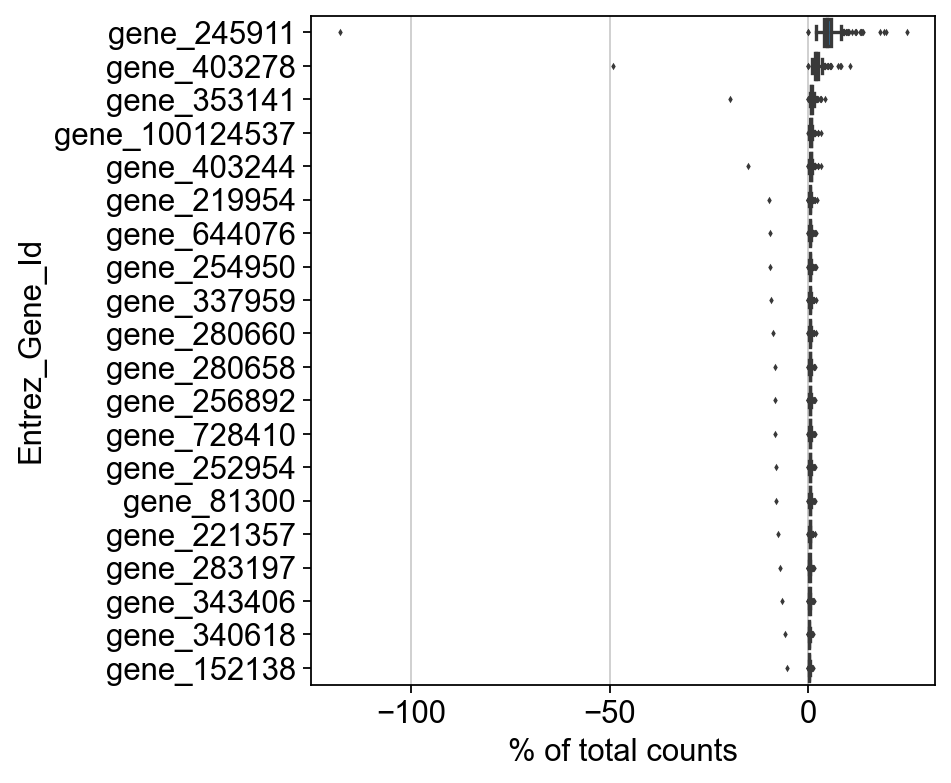

In [9]:
sc.pl.highest_expr_genes(adata, n_top=20, )
#Show those genes that yield the highest fraction of counts in each single cell, across all cells.

Clustering

computing PCA
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:07)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)
running Leiden clustering
    finished: found 9 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


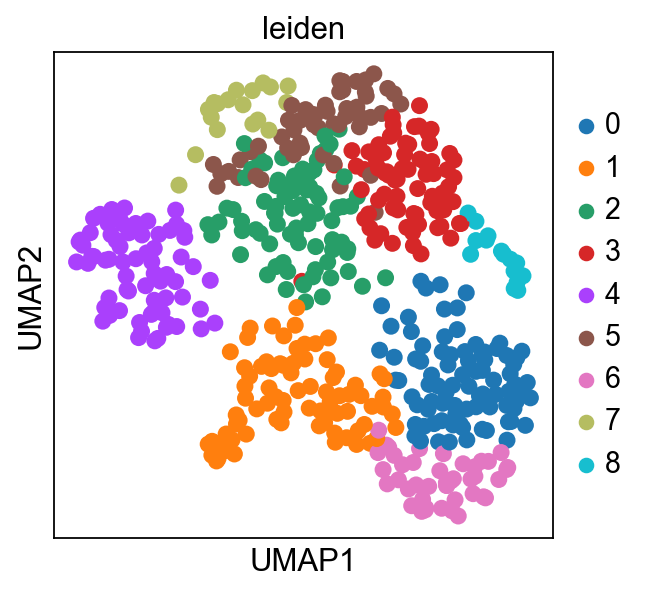

In [10]:
sc.tl.pca(adata, n_comps=50)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata)
sc.pl.umap(adata, color='leiden')

In [11]:
pd.DataFrame(adata.obs['leiden'])

,leiden
TCGA-CS-4938-01,2
TCGA-CS-4941-01,4
TCGA-CS-4942-01,2
TCGA-CS-4943-01,7
TCGA-CS-4944-01,2
...,...
TCGA-WY-A85A-01,3
TCGA-WY-A85B-01,5
TCGA-WY-A85C-01,5
TCGA-WY-A85D-01,3


In [12]:
print("Explained variance of PCA:" , adata.uns['pca']['variance_ratio'].sum())

Explained variance of PCA: 0.7036328


In [13]:
clusters_df = pd.DataFrame(adata.obs['leiden']).reset_index(level=0)
clusters_df['index'] = clusters_df['index'].str[:-3]

Clinical Patient Data

In [14]:
data_patient = pd.read_table('data/data_clinical_patient.txt', sep='\t')
print(data_patient.iloc[0])


#Patient Identifier                                                                                   #Identifier to uniquely specify a patient.
Subtype                                                                                                                                  Subtype
TCGA PanCanAtlas Cancer Type Acronym                                                           Text field to hold cancer type acronym used by...
Other Patient ID                                                                                         Legacy DMP patient identifier (DMPnnnn)
Diagnosis Age                                                                                  Age at which a condition or disease was first ...
Sex                                                                                                                                          Sex
Neoplasm Disease Stage American Joint Committee on Cancer Code                                 The extent of a cancer, especially 

In [15]:
data_patient = data_patient.drop([0,1,2,3], axis = 0)
df_patient = data_patient.reset_index(drop=True)

In [16]:
df_patient.head()

,#Patient Identifier,Subtype,TCGA PanCanAtlas Cancer Type Acronym,Other Patient ID,Diagnosis Age,Sex,Neoplasm Disease Stage American Joint Committee on Cancer Code,American Joint Committee on Cancer Publication Version Type,Last Communication Contact from Initial Pathologic Diagnosis Date,Birth from Initial Pathologic Diagnosis Date,...,Patient Weight,In PanCan Pathway Analysis,Overall Survival Status,Overall Survival (Months),Disease-specific Survival status,Months of disease-specific survival,Disease Free Status,Disease Free (Months),Progression Free Status,Progress Free Survival (Months)
0,TCGA-CS-4938,LGG_IDHmut-non-codel,LGG,334f715e-08dc-4a29-b8e4-b010b829c478,31,Female,NaN,NaN,3574,-11509,...,NaN,Yes,0:LIVING,117.5000822,0:ALIVE OR DEAD TUMOR FREE,117.5000822,NaN,NaN,0:CENSORED,117.5000822
1,TCGA-CS-4941,LGG_IDHwt,LGG,fc222f23-b3b2-4ac0-bc61-e8e8fa5cc160,67,Male,NaN,NaN,NaN,-24578,...,NaN,Yes,1:DECEASED,7.693066377,1:DEAD WITH TUMOR,7.693066377,NaN,NaN,1:PROGRESSION,0.295887168
2,TCGA-CS-4942,LGG_IDHmut-non-codel,LGG,230f5fa7-aa36-41ea-b40b-08f520767bd5,44,Female,NaN,NaN,NaN,-16297,...,NaN,Yes,1:DECEASED,43.88992997,1:DEAD WITH TUMOR,43.88992997,NaN,NaN,1:PROGRESSION,38.92560082
3,TCGA-CS-4943,LGG_IDHmut-non-codel,LGG,952dfd5d-e65a-4307-b6a9-2ed2b0d2d9ce,37,Male,NaN,NaN,552,-13565,...,NaN,Yes,1:DECEASED,36.36124536,1:DEAD WITH TUMOR,36.36124536,NaN,NaN,1:PROGRESSION,36.36124536
4,TCGA-CS-4944,LGG_IDHmut-non-codel,LGG,64cd17eb-c778-45e9-b994-02b68182e51b,50,Male,NaN,NaN,1828,-18494,...,NaN,Yes,0:LIVING,60.09797153,0:ALIVE OR DEAD TUMOR FREE,60.09797153,NaN,NaN,0:CENSORED,60.09797153


Adding statistical clusters to patient data

In [68]:
df_patient_clusters = pd.merge(left=df_patient, right=clusters_df, left_on='#Patient Identifier', right_on="index")
df_patient_clusters

,#Patient Identifier,Subtype,TCGA PanCanAtlas Cancer Type Acronym,Other Patient ID,Diagnosis Age,Sex,Neoplasm Disease Stage American Joint Committee on Cancer Code,American Joint Committee on Cancer Publication Version Type,Last Communication Contact from Initial Pathologic Diagnosis Date,Birth from Initial Pathologic Diagnosis Date,...,Overall Survival Status,Overall Survival (Months),Disease-specific Survival status,Months of disease-specific survival,Disease Free Status,Disease Free (Months),Progression Free Status,Progress Free Survival (Months),index,leiden
0,TCGA-CS-4938,LGG_IDHmut-non-codel,LGG,334f715e-08dc-4a29-b8e4-b010b829c478,31,Female,NaN,NaN,3574,-11509,...,0:LIVING,117.5000822,0:ALIVE OR DEAD TUMOR FREE,117.5000822,NaN,NaN,0:CENSORED,117.5000822,TCGA-CS-4938,2
1,TCGA-CS-4941,LGG_IDHwt,LGG,fc222f23-b3b2-4ac0-bc61-e8e8fa5cc160,67,Male,NaN,NaN,NaN,-24578,...,1:DECEASED,7.693066377,1:DEAD WITH TUMOR,7.693066377,NaN,NaN,1:PROGRESSION,0.295887168,TCGA-CS-4941,4
2,TCGA-CS-4942,LGG_IDHmut-non-codel,LGG,230f5fa7-aa36-41ea-b40b-08f520767bd5,44,Female,NaN,NaN,NaN,-16297,...,1:DECEASED,43.88992997,1:DEAD WITH TUMOR,43.88992997,NaN,NaN,1:PROGRESSION,38.92560082,TCGA-CS-4942,2
3,TCGA-CS-4943,LGG_IDHmut-non-codel,LGG,952dfd5d-e65a-4307-b6a9-2ed2b0d2d9ce,37,Male,NaN,NaN,552,-13565,...,1:DECEASED,36.36124536,1:DEAD WITH TUMOR,36.36124536,NaN,NaN,1:PROGRESSION,36.36124536,TCGA-CS-4943,7
4,TCGA-CS-4944,LGG_IDHmut-non-codel,LGG,64cd17eb-c778-45e9-b994-02b68182e51b,50,Male,NaN,NaN,1828,-18494,...,0:LIVING,60.09797153,0:ALIVE OR DEAD TUMOR FREE,60.09797153,NaN,NaN,0:CENSORED,60.09797153,TCGA-CS-4944,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509,TCGA-WY-A85B,LGG_IDHmut-non-codel,LGG,CB041720-0EFA-4EB6-A9A5-B6E138BB1A99,24,Male,NaN,NaN,1393,-8817,...,0:LIVING,45.79675839,0:ALIVE OR DEAD TUMOR FREE,45.79675839,0:DiseaseFree,45.79675839,0:CENSORED,45.79675839,TCGA-WY-A85B,5
510,TCGA-WY-A85C,LGG_IDHmut-non-codel,LGG,F62BE2B8-88C4-4A7E-8C80-8176FB5F6C56,36,Male,NaN,NaN,1426,-13506,...,0:LIVING,46.88167801,0:ALIVE OR DEAD TUMOR FREE,46.88167801,NaN,NaN,1:PROGRESSION,26.5969688,TCGA-WY-A85C,5
511,TCGA-WY-A85D,LGG_IDHmut-non-codel,LGG,0D5A4C63-C3FB-4295-A433-D90CDBFC4ED6,60,Male,NaN,NaN,1147,-21979,...,0:LIVING,37.70917579,0:ALIVE OR DEAD TUMOR FREE,37.70917579,NaN,NaN,1:PROGRESSION,29.16132426,TCGA-WY-A85D,3
512,TCGA-WY-A85E,LGG_IDHmut-non-codel,LGG,2272DFF7-A509-496F-B500-467C1BCE2F79,48,Female,NaN,NaN,633,-17878,...,0:LIVING,20.81073084,0:ALIVE OR DEAD TUMOR FREE,20.81073084,NaN,NaN,1:PROGRESSION,17.49021929,TCGA-WY-A85E,3


In [18]:
droper = ['Other Patient ID',  'Neoplasm Disease Stage American Joint Committee on Cancer Code',
       'American Joint Committee on Cancer Publication Version Type',
       'Last Communication Contact from Initial Pathologic Diagnosis Date','Form completion date',
       'Informed consent verified','Form completion date',
       'Neoadjuvant Therapy Type Administered Prior To Resection Text',
       'ICD-10 Classification',
       'International Classification of Diseases for Oncology, Third Edition ICD-O-3 Histology Code',
       'International Classification of Diseases for Oncology, Third Edition ICD-O-3 Site Code',  
        'New Neoplasm Event Post Initial Therapy Indicator',
       'American Joint Committee on Cancer Metastasis Stage Code',
       'Neoplasm Disease Lymph Node Stage American Joint Committee on Cancer Code',
       'American Joint Committee on Cancer Tumor Stage Code',
       'TCGA PanCanAtlas Cancer Type Acronym', 'Disease Free Status', "Patient Weight",
       'Disease Free (Months)', 'Ethnicity Category','Primary Lymph Node Presentation Assessment',
       'index','Progress Free Survival (Months)', 'Months of disease-specific survival',
        'Disease-specific Survival status', 'Progression Free Status'

       ]

In [69]:
df_patient_clusters = df_patient_clusters.drop(droper, axis=1).reset_index(drop=True)

Adding genes to patient data

In [70]:
df_clean['ID'] = df_clean.index
df_clean['ID'] = df_clean['ID'].str[:-3]


In [71]:
binary_columns = ['Overall Survival Status']
for col in binary_columns:
    df_patient_clusters[col] = pd.to_numeric(df_patient_clusters[col].str[0])

Encoding

In [72]:
df_patient_clusters['Person Neoplasm Cancer Status'] = df_patient_clusters['Person Neoplasm Cancer Status'].map({'With Tumor': 1, 'Tumor Free': 0})
df_patient_clusters['Prior Diagnosis'] = df_patient_clusters['Prior Diagnosis'].map({'Yes': 1, 'No': 0})
df_patient_clusters['Radiation Therapy'] = df_patient_clusters['Radiation Therapy'].map({'Yes': 1, 'No': 0})
df_patient_clusters['In PanCan Pathway Analysis'] = df_patient_clusters['In PanCan Pathway Analysis'].map({'Yes': 1, 'No': 0})
df_patient_clusters['Sex'] = df_patient_clusters['Sex'].map({'Male': 1, 'Female': 0})

In [158]:
# perform one-hot encoding 
cat_data = ['Race Category','Subtype']
df_patient_clusters_enc = df_patient_clusters
for feature in cat_data:
    encoded_df = pd.get_dummies(df_patient_clusters_enc[feature])
    # cncatenate the original dataframe with the encoded dataframe
    df_patient_clusters_enc = pd.concat([df_patient_clusters_enc, encoded_df], axis=1)
    # drop the original categorical column
df_patient_clusters_enc.drop(cat_data, axis=1, inplace=True)

In [159]:
df_genes = df_clean
df_genes['ID'] = df_genes.index.str[:-3]
df_genes = df_genes.reset_index(drop=True)

In [178]:
df_ML = pd.merge(df_patient_clusters_enc, df_genes, left_on='#Patient Identifier', right_on='ID').drop('ID', axis=1)
df_ML= df_ML.loc[:, ~df_ML.columns.duplicated()].drop('#Patient Identifier', axis=1)
df_ML['Overall Survival Status'] = df_ML['Overall Survival Status'].fillna(df_ML['Overall Survival Status'].mode()[0])
df_ML['Overall Survival (Months)'] = df_ML['Overall Survival (Months)'].fillna(df_ML['Overall Survival (Months)'].median())

 Preprocessing

In [180]:
var = ['Overall Survival (Months)']


y = df_ML[var].apply(pd.to_numeric)
y = StandardScaler().fit_transform(y)

X = df_ML.drop(var, axis=1).reset_index(drop=True)
X = X.drop(['Overall Survival Status', ],
            axis=1).reset_index(drop=True) # should not be predictors aka Leakage


In [184]:
categorical_features = ['Sex','Person Neoplasm Cancer Status', 'Prior Diagnosis',
                            'Radiation Therapy','In PanCan Pathway Analysis', 'American Indian or Alaska Native','White',
                            'Asian','Black or African American','LGG_IDHmut-codel','LGG_IDHmut-non-codel','LGG_IDHwt',
                            #'Overall Survival Status'
                            ]

numeric_features = X.drop(categorical_features, axis=1)
numeric_features = numeric_features.columns.tolist()


numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
    ])

#Replacing missing values with Modal value and then one hot encoding.
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ])

preprocessor = ColumnTransformer(transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
            ])


In [185]:
#Fit your preprocessor object
X_surv=preprocessor.fit_transform(X) 

In [186]:
X_train, X_test, y_train, y_test = train_test_split(
    X_surv, y, random_state=42)

## 🏆 Survival Models

In [191]:
y_surv = pd.concat([df_ML['Overall Survival Status'].astype(bool), df_ML['Overall Survival (Months)'].apply(pd.to_numeric)], axis=1).to_records(index=False)

In [192]:

X_train, X_test, y_train, y_test = train_test_split(
    X_surv, y_surv, random_state=42)

### Random Survival Forest

In [193]:
rsf = RandomSurvivalForest(n_estimators=10,
                           min_samples_split=2,
                           min_samples_leaf=1,
                           n_jobs=-1,
                           random_state=42)

In [194]:
rsf.fit(X_train, y_train)

RandomSurvivalForest(min_samples_leaf=1, min_samples_split=2, n_estimators=10,
                     n_jobs=-1, random_state=42)

In [195]:
print("Train score: {:.3f}".format(rsf.score(X_train, y_train)), "\nTest score: {:.3f}".format(rsf.score(X_test, y_test)))

Train score: 0.964 
Test score: 0.742


### Gradient Boosting Survival

In [196]:
est_cph_tree = GradientBoostingSurvivalAnalysis(
    n_estimators=10, learning_rate=1.0, max_depth=1, random_state=42
)
est_cph_tree.fit(X_train, y_train)

GradientBoostingSurvivalAnalysis(learning_rate=1.0, max_depth=1,
                                 n_estimators=10, random_state=42)

In [197]:
print("Train score: {:.3f}".format(est_cph_tree.score(X_train, y_train)), "\nTest score: {:.3f}".format(est_cph_tree.score(X_test, y_test)))

Train score: 0.887 
Test score: 0.808


### Elastic Net Cox Model

In [198]:
cox_net = CoxnetSurvivalAnalysis(l1_ratio= 0.9,
                                  alpha_min_ratio= 0.25,
                                    fit_baseline_model=True)
cox_net.fit(X_train, y_train)

CoxnetSurvivalAnalysis(alpha_min_ratio=0.25, fit_baseline_model=True,
                       l1_ratio=0.9)

In [ ]:
cv=False

In [ ]:
if cv==True:
    cox_elastic_net = CoxnetSurvivalAnalysis(fit_baseline_model=True)
    params = {'l1_ratio':np.arange(0.4,1.,0.05), "alpha_min_ratio":np.arange(0.1,0.7,0.05)}
    cox_net_cv = GridSearchCV(cox_elastic_net,
                        param_grid=params,
                        n_jobs=-1,
                        cv=10,
                        )
    cox_net_cv.fit(X_train, y_train)
    #extract best score and parameter by calling objects "best_score_" and "best_params_"
    print("best mean cross-validation score: {:.3f}".format(cox_net_cv.best_score_))
    print("best parameters: {}".format(cox_net_cv.best_params_))
    print("Train score: {:.3f}".format(cox_net_cv.score(X_train, y_train)), "\nTest score: {:.3f}".format(cox_net_cv.score(X_test, y_test)))
    cox_net = cox_net_cv.best_estimator_

In [ ]:
if cv==True:
    estimated_alphas = cox_net.alphas_
    cv = KFold(n_splits=5, shuffle=True, random_state=0)
    gcv = GridSearchCV(
        make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.25, fit_baseline_model=True)),
        param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in estimated_alphas]},
        cv=cv,
        error_score=0.5,
        n_jobs=-1)
    gcv.fit(X_train, y_train)
    cox_net = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]

In [199]:
best_model = cox_net

In [200]:
print("Train score: {:.3f}".format(best_model.score(X_train, y_train)), "\nTest score: {:.3f}".format(best_model.score(X_test, y_test)))

Train score: 0.937 
Test score: 0.871


#### Feature Importance

Number of non-zero coefficients: 64


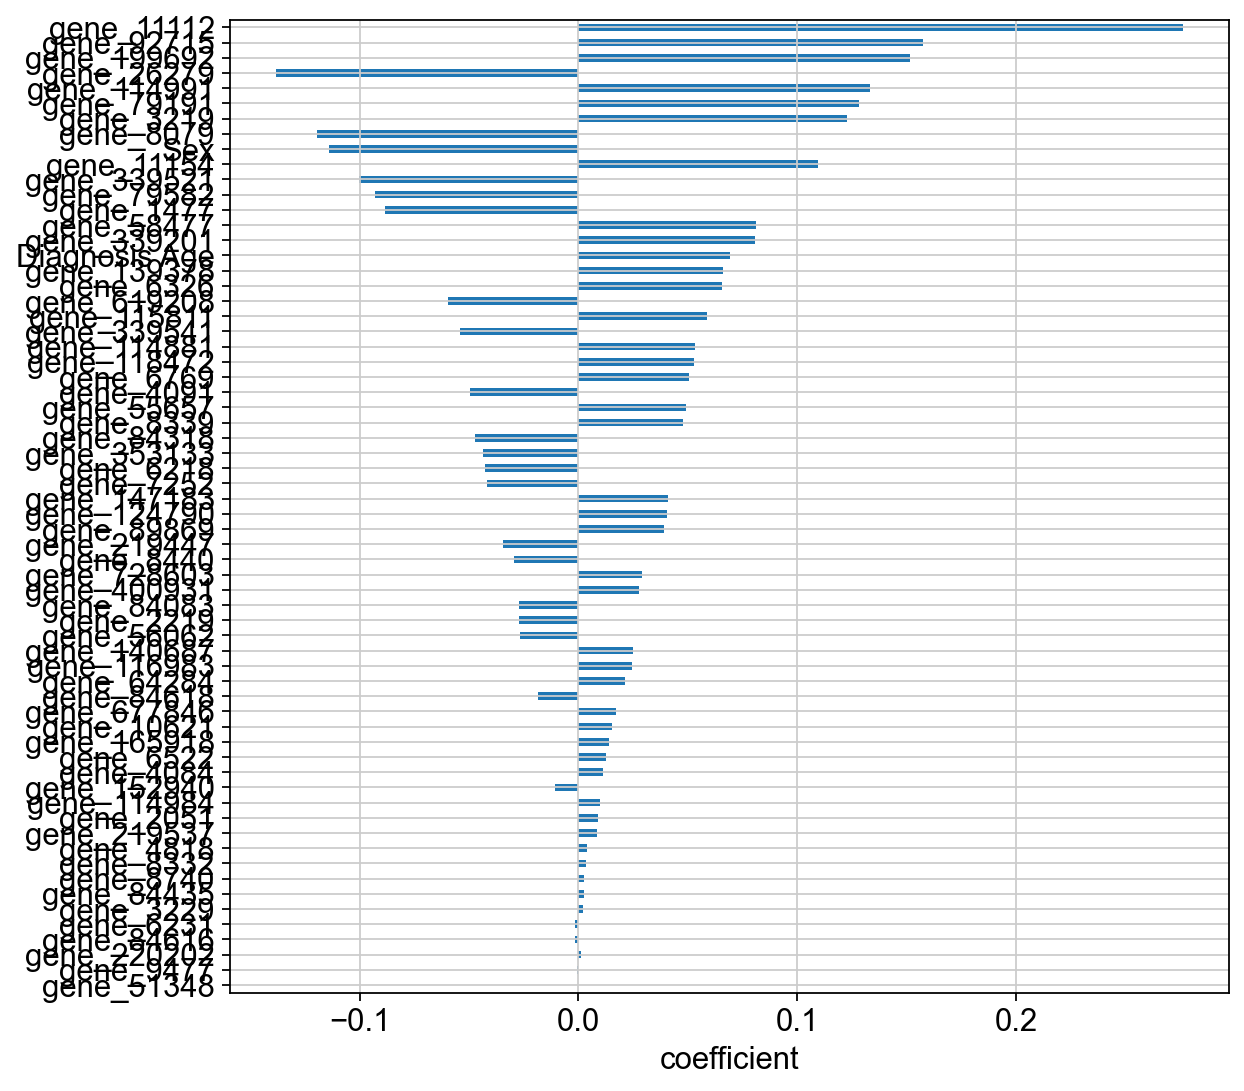

In [201]:
best_coefs = pd.DataFrame(
    best_model.coef_[:,-1],
    index=X.columns,
    columns=["coefficient"]
)

non_zero = np.sum(best_coefs.iloc[:, 0] != 0)
print("Number of non-zero coefficients: {}".format(non_zero))

non_zero_coefs = best_coefs.query("coefficient != 0")
coef_order = non_zero_coefs.abs().sort_values("coefficient").index

_, ax = plt.subplots(figsize=(8, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False,)
ax.set_xlabel("coefficient")
ax.grid(True)

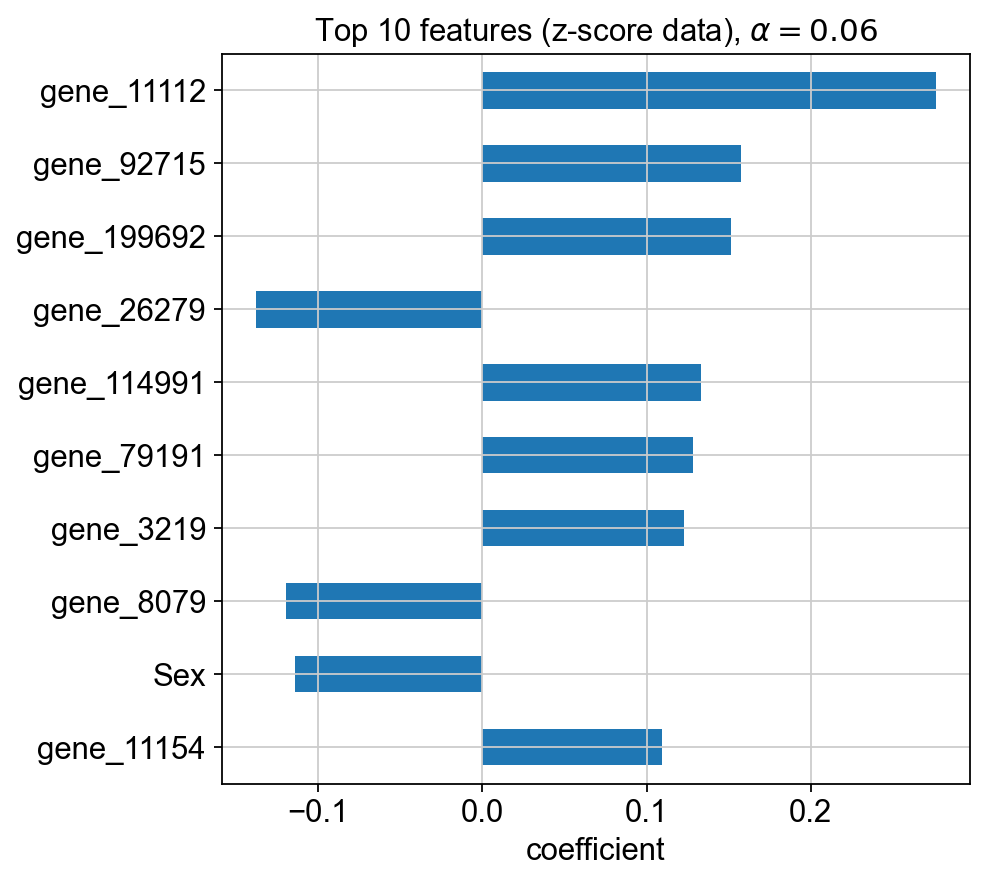

In [202]:
_, ax = plt.subplots(figsize=(6, 6))
alpha = round(best_model.alphas_[-1],2)
non_zero_coefs.loc[coef_order]['coefficient'].tail(10).plot.barh(ax=ax, legend=False)
ax.set_xlabel("coefficient")
ax.set_title(f'Top 10 features (z-score data), $\\alpha={alpha} $')
ax.grid(True)

#### Survival Curves

Text(0.5, 0, 'time $t$')

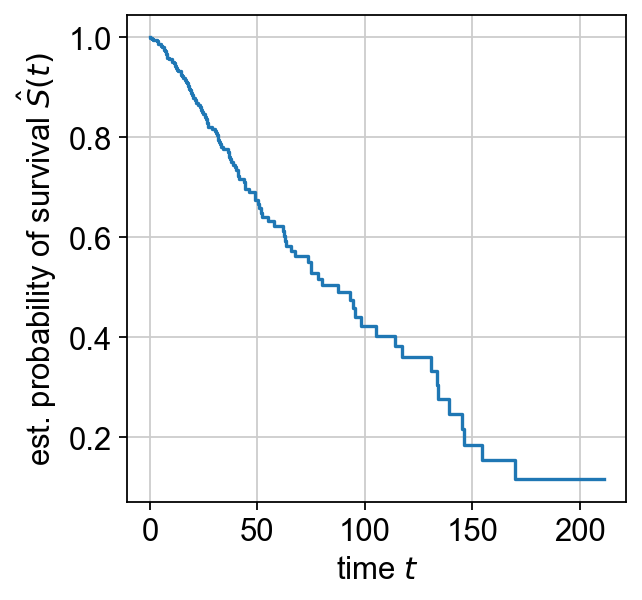

In [203]:
from sksurv.nonparametric import kaplan_meier_estimator

time, survival_prob = kaplan_meier_estimator(df_ML["Overall Survival Status"].astype(bool), df_ML['Overall Survival (Months)'])
plt.step(time, survival_prob, where="post")
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


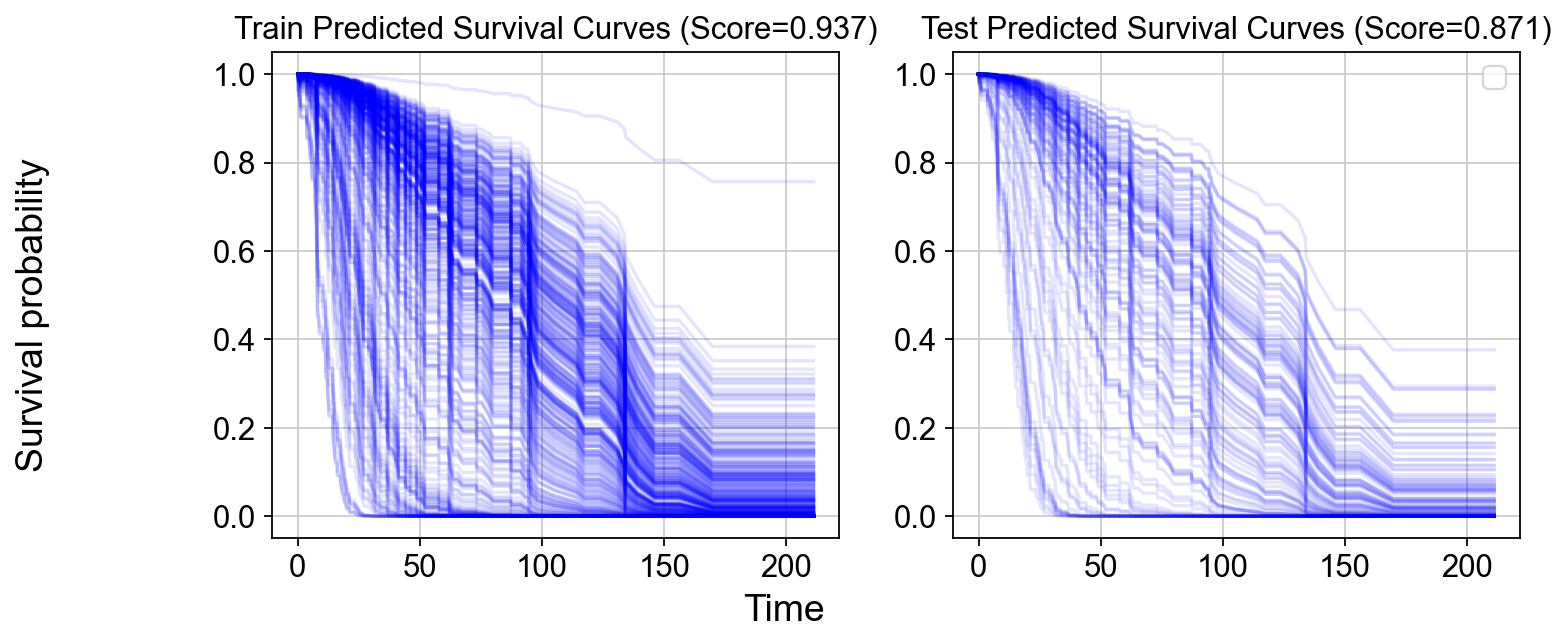

In [204]:
survival_function_test = best_model.predict_survival_function(X_test, return_array=False)
survival_function_train = best_model.predict_survival_function(X_train, return_array=False)
score_test = best_model.score(X_test, y_test)
score_train = best_model.score(X_train, y_train)

fig, ax = plt.subplots(1,2, figsize=(10,4))

for i, (a, b) in enumerate(y_train):
    ax[0].plot(survival_function_train[i].x, survival_function_train[i].y, alpha=0.1, c='blue')
for i, (a, b) in enumerate(y_test):
    ax[1].plot(survival_function_test[i].x, survival_function_test[i].y, alpha=0.1, c='blue')

fig.supxlabel('Time')
fig.supylabel('Survival probability')

ax[0].set_title(f'Train Predicted Survival Curves (Score={score_train:.3f})')
ax[1].set_title(f'Test Predicted Survival Curves (Score={score_test:.3f})')
plt.legend()
plt.show()


#### Exploration:  PCA Elastic Net Model 

In [ ]:
# n=50

# pca_train = KernelPCA(n_components=n, kernel='rbf', fit_inverse_transform=True)
# pca_test = KernelPCA(n_components=n, kernel='rbf', fit_inverse_transform=True)

# X_train_pca = pca_train.fit_transform(X_train)
# X_test_pca = pca_test.fit_transform(X_test)
# y_train_pca = y_train
# y_test_pca = y_test


In [205]:
n = 50
pca = KernelPCA(n_components=n,
                 kernel='poly',
                 degree=3,
                 #gamma=1e-7,
                 fit_inverse_transform=True)
umap = UMAP()
tsne = TSNE()
X_pca = pca.fit_transform(X_surv)
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(
    X_pca, y_surv, random_state=42)

In [206]:
best_model.fit(X_train_pca, y_train_pca)

CoxnetSurvivalAnalysis(alpha_min_ratio=0.25, fit_baseline_model=True,
                       l1_ratio=0.9)

In [207]:

print("Train score: {:.3f}".format(best_model.score(X_train_pca, y_train_pca)), "\nTest score: {:.3f}".format(best_model.score(X_test_pca, y_test_pca)))


Train score: 0.770 
Test score: 0.812


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


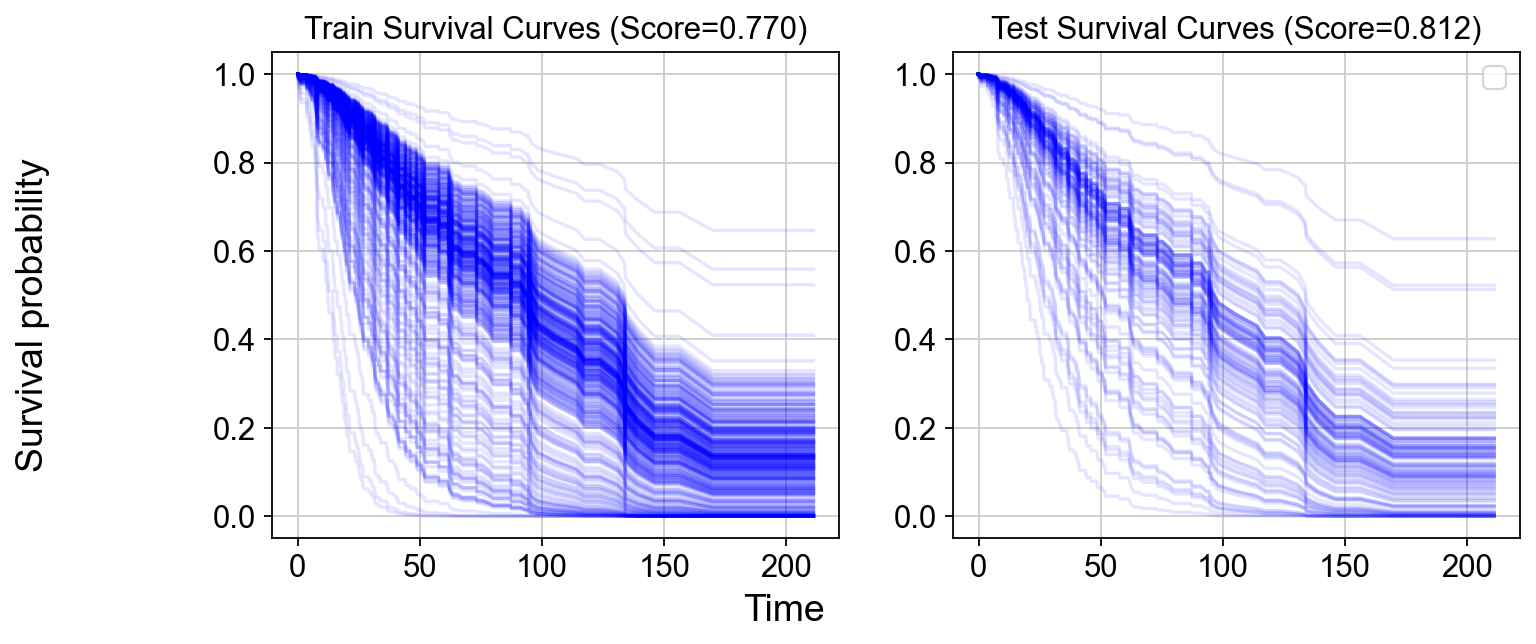

In [208]:
survival_function_test = best_model.predict_survival_function(X_test_pca, return_array=False)
survival_function_train = best_model.predict_survival_function(X_train_pca, return_array=False)
score_test = best_model.score(X_test_pca, y_test_pca)
score_train = best_model.score(X_train_pca, y_train_pca)

fig, ax = plt.subplots(1,2, figsize=(10,4))

for i, (a, b) in enumerate(y_train):
    ax[0].plot(survival_function_train[i].x, survival_function_train[i].y, alpha=0.1, c='blue')
for i, (a, b) in enumerate(y_test):
    ax[1].plot(survival_function_test[i].x, survival_function_test[i].y, alpha=0.1, c='blue')

fig.supxlabel('Time')
fig.supylabel('Survival probability')

ax[0].set_title(f'Train Survival Curves (Score={score_train:.3f})')
ax[1].set_title(f'Test Survival Curves (Score={score_test:.3f})')
plt.legend()
plt.show()

 Interpretation

In [209]:
coef  =  best_model.coef_[:,-1].reshape(-1,1)

# project back from n components,1 -> to 20K, 1 
coef_proj = pca.inverse_transform(coef.T).T

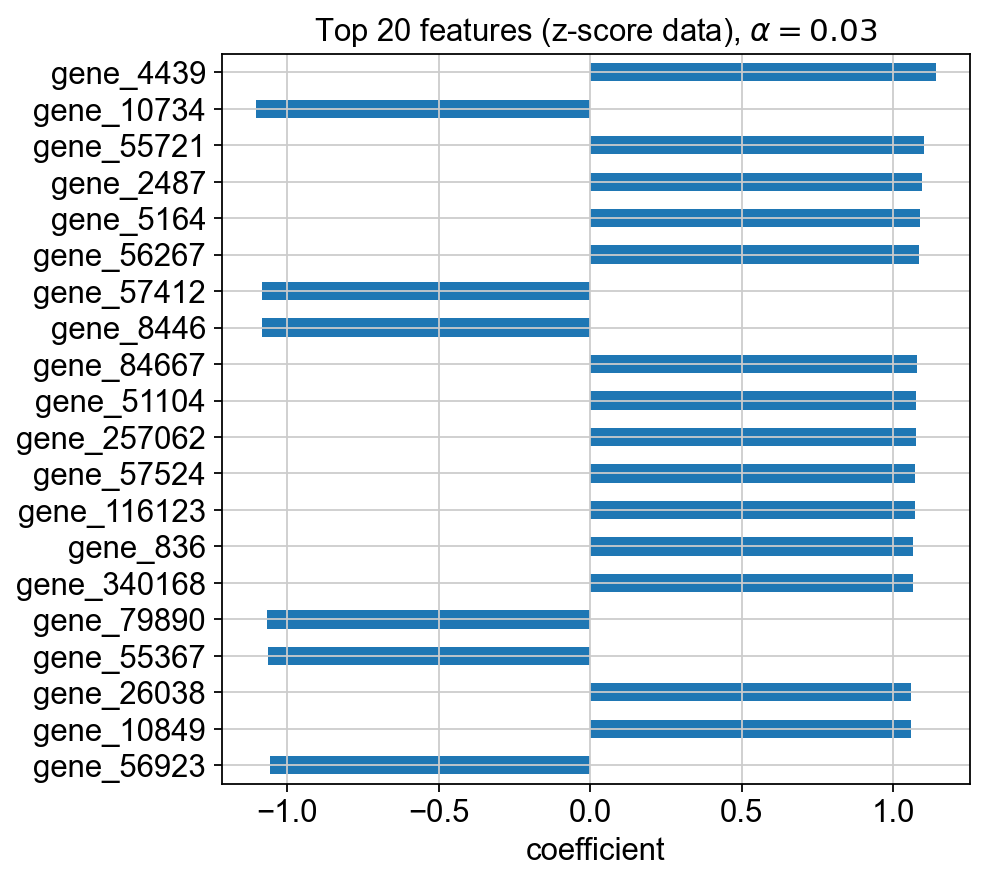

In [210]:
best_coefs = pd.DataFrame(
    coef_proj,
    index=X.columns,
    columns=["coefficient"]
)

non_zero_coefs = best_coefs.query("coefficient != 0")
coef_order = non_zero_coefs.abs().sort_values("coefficient").index


_, ax = plt.subplots(figsize=(6, 6))
alpha = round(best_model.alphas_[-1],2)
n_top=20
non_zero_coefs.loc[coef_order]['coefficient'].tail(n_top).plot.barh(ax=ax, legend=False)
ax.set_xlabel("coefficient")
ax.set_title(f'Top {n_top} features (z-score data), $\\alpha={alpha} $')
ax.grid(True)

**Results are very different from non PCA Data!!**

- The lead features are very different
- the choice of kernel matters a lot: RBF has good performance but shrinks to the mean, I prefer Poly
- This model seems very unstable

## Look at grouping patients

Text(0.5, 0.01, 'time $t$')

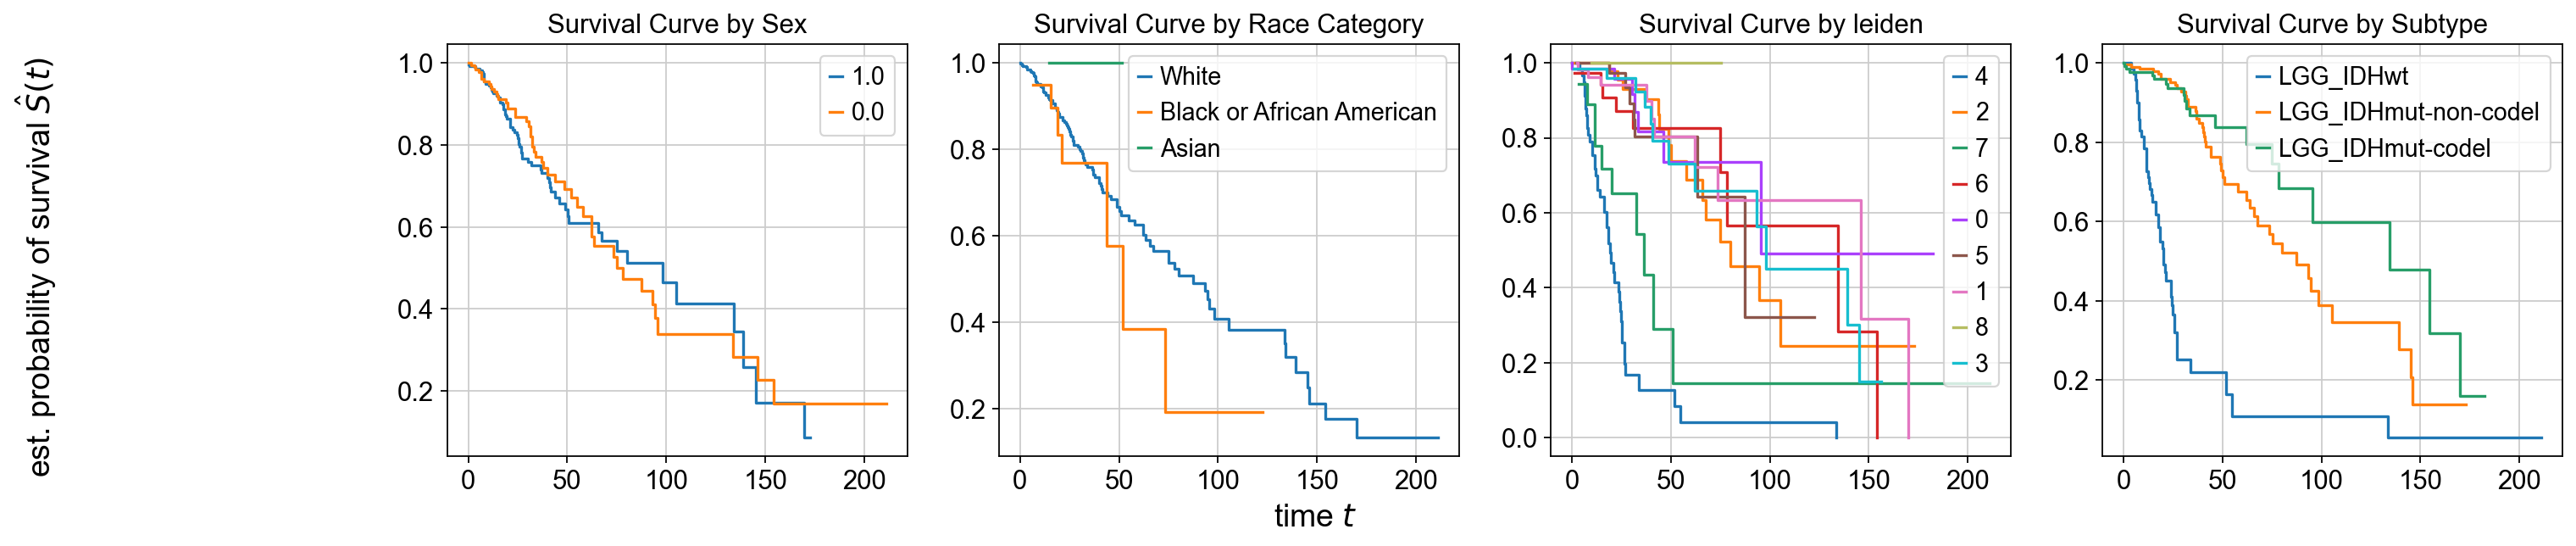

In [212]:
df_patient_clusters = df_patient_clusters.dropna(axis=0)
vars = ['Sex', 'Race Category', 'leiden', 'Subtype']
n = len(vars)
fig, ax = plt.subplots(1,n, figsize=(20,4))
for i in range(n):
    var = vars[i]
    for value in df_patient_clusters[var].unique():
        mask = df_patient_clusters[var] == value
        time_cell, survival_prob_cell = kaplan_meier_estimator(df_patient_clusters["Overall Survival Status"].astype(bool)[mask],
                                                            df_patient_clusters["Overall Survival (Months)"][mask])
        
        ax[i].step(time_cell, survival_prob_cell, where="post",
                   label=value)
        ax[i].set_title(f'Survival Curve by {var}')
        ax[i].legend(loc="best")

fig.supylabel("est. probability of survival $\hat{S}(t)$")
fig.supxlabel("time $t$")
